###  Using the class spectral analysis

Tutorial on how to use the spectral analysis class to compute power spectrum, spectogram, and the pairwise coherence.

In [1]:
%matplotlib inline

import numpy               as     np
import matplotlib.pyplot   as     plt
from GDa.spectral_analysis import spectral, spectral_analysis
from GDa.session           import session

The class __spectral_analysis__ inherits from a more general class named __spectral__. Let's start by using the __spectral__ class:

In [2]:
spec = spectral()

To use the object __spec__ first we read a sample LFP signal:

In [3]:
data = np.load('raw_lfp/lucy_session01_150304.npy',allow_pickle=True).item()['data']
N    = data.shape[2]   # Number of time points 
fs   = 1000            # Sampling frequency  [Hz]

Next, we will select a random LFP signal in data:

In [4]:
lfp   = data[0,10,:]
lfp2  = data[0,30,:]
# Time axis, using from -0.65 to 3.00 s because this is the event dt we used when we saved the data
time = np.linspace(-0.65, 3.00, lfp.shape[-1]) 

Text(0, 0.5, 'mV')

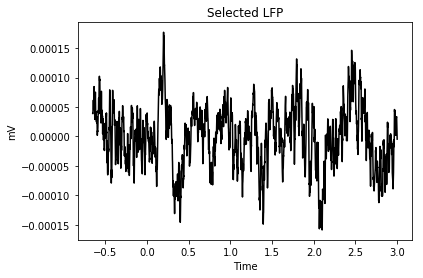

In [5]:
# Plotting the signal
plt.plot(time, lfp, 'k')
plt.title('Selected LFP')
plt.xlabel('Time')
plt.ylabel('mV')

We can bandpass filter the signal with the function __filter__ in __spectral__, let's filter it on the alpha band (8-12 Hz):

In [6]:
lfp_filterd = spec.filter(signal = lfp, fs = fs, f_low = 8, f_high = 12, n_jobs = -1)

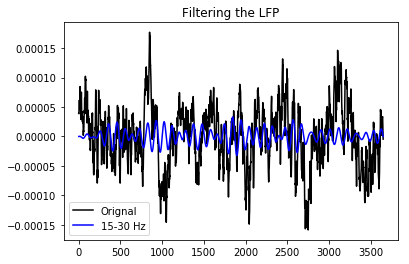

In [7]:
plt.plot(lfp, 'k')
plt.plot(lfp_filterd, 'b')
plt.title('Filtering the LFP')
plt.legend(['Orignal', '15-30 Hz'])

We can compute the spectogram of the signal using the function __wavelet_spectogram__, which allows to use morlet or multitaper transforms, or the function __garbor_spectogram__ (not built upon MNE). If we pass a second signal to those methods it will compute both the auto- and cross-spectra for the signal.

In [8]:
# Defining frequencies
freqs = np.arange(4,30,.1)

# Morlet
Sxx_ml, Syy_ml, Sxy_ml = spec.wavelet_spectrum(signal1 = lfp[np.newaxis, np.newaxis, :], 
                                               signal2 = lfp2[np.newaxis, np.newaxis, :], 
                                               fs = fs, freqs = freqs, n_cycles = 5.0,
                                               win_time=500, win_freq=1, 
                                               time_bandwidth = None, method = 'morlet', n_jobs = -1)

# Multitaper
Sxx_mt, Syy_mt, Sxy_mt = spec.wavelet_spectrum(signal1 = lfp[np.newaxis, np.newaxis, :], 
                                               signal2 = lfp2[np.newaxis, np.newaxis, :], 
                                               fs = fs, freqs = freqs, n_cycles = 5.0,
                                               win_time=500, win_freq=1,
                                               time_bandwidth = None, method = 'multitaper', n_jobs = -1)

# Garbor
Sxx_gb, Syy_gb, Sxy_gb = spec.gabor_spectrum(signal1 = lfp, 
                                             signal2 = lfp2, 
                                             fs = fs, freqs = freqs, n_cycles = 5.0,
                                              win_time = 500, win_freq = 1)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.9s finished


Next, we can visualize the result:

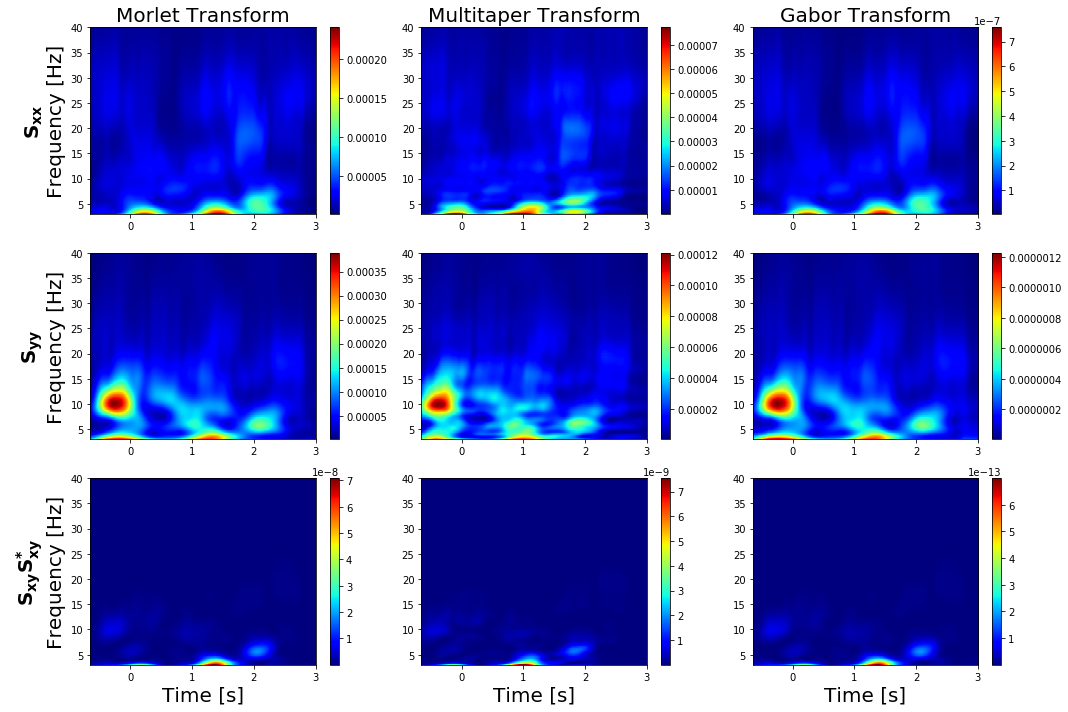

In [9]:
plt.figure(figsize=(15,10))
# Sxx
plt.subplot(3,3,1)
plt.imshow(Sxx_ml.real, aspect='auto', cmap='jet', origin='lower', extent=[-0.65,3.00,3,40]);plt.colorbar()
plt.title('Morlet Transform', fontsize=20)
plt.ylabel(r"$\bf{S_{xx}}$" + "\n" + "Frequency [Hz]", fontsize=20)
plt.subplot(3,3,2)
plt.imshow(Sxx_mt.real, aspect='auto', cmap='jet', origin='lower', extent=[-0.65,3.00,3,40]);plt.colorbar()
plt.title('Multitaper Transform', fontsize=20)
plt.subplot(3,3,3)
plt.imshow(Sxx_gb.real, aspect='auto', cmap='jet', origin='lower', extent=[-0.65,3.00,3,40]);plt.colorbar()
plt.title('Gabor Transform', fontsize=20)

# Syy
plt.subplot(3,3,4)
plt.imshow(Syy_ml.real, aspect='auto', cmap='jet', origin='lower', extent=[-0.65,3.00,3,40]);plt.colorbar()
plt.ylabel(r"$\bf{S_{yy}}$" + "\n" + "Frequency [Hz]", fontsize=20)
plt.subplot(3,3,5)
plt.imshow(Syy_mt.real, aspect='auto', cmap='jet', origin='lower', extent=[-0.65,3.00,3,40]);plt.colorbar()
plt.subplot(3,3,6)
plt.imshow(Syy_gb.real, aspect='auto', cmap='jet', origin='lower', extent=[-0.65,3.00,3,40]);plt.colorbar()

# Sxy
plt.subplot(3,3,7)
plt.imshow((Sxy_ml*np.conj(Sxy_ml)).real, aspect='auto', cmap='jet', origin='lower', extent=[-0.65,3.00,3,40]);plt.colorbar()
plt.ylabel(r"$\bf{S_{xy}S_{xy}^{*}}$" + "\n" + "Frequency [Hz]", fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.subplot(3,3,8)
plt.imshow((Sxy_mt*np.conj(Sxy_mt)).real, aspect='auto', cmap='jet', origin='lower', extent=[-0.65,3.00,3,40]);plt.colorbar()
plt.xlabel('Time [s]', fontsize=20)
plt.subplot(3,3,9)
plt.imshow((Sxy_gb*np.conj(Sxy_gb)).real, aspect='auto', cmap='jet', origin='lower', extent=[-0.65,3.00,3,40]);plt.colorbar()
plt.xlabel('Time [s]', fontsize=20)

plt.tight_layout()

Finally we can compute the time-frequency coherence between two signals by using the function __wavelet_coherence__, or __gabor_coherence__.

In [10]:
# Morlet
coh_ml  = spec.wavelet_coherence(signal1=lfp[np.newaxis, np.newaxis, :], 
                                 signal2=lfp2[np.newaxis, np.newaxis, :],
                                 fs=fs,freqs=freqs,n_cycles=5.0,
                                 win_time=500, win_freq=1, method='morlet',n_jobs=-1)

# Multitaper
coh_mt  = spec.wavelet_coherence(signal1=lfp[np.newaxis, np.newaxis, :], 
                                 signal2=lfp2[np.newaxis, np.newaxis, :],
                                 fs=fs,freqs=freqs,n_cycles=5.0, time_bandwidth=None,
                                 win_time=500, win_freq=1, method='multitaper',n_jobs=-1)

# Gabor
coh_gb = spec.gabor_coherence(signal1=lfp, 
                              signal2=lfp2, 
                              fs=fs, freqs=freqs,n_cycles = 5.0,
                              win_time=500, win_freq = 1)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.9s finished


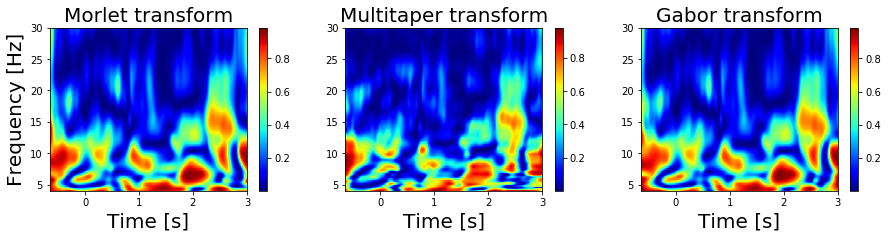

In [14]:
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.title('Morlet transform', fontsize=20)
plt.imshow(np.squeeze(coh_ml.real), aspect='auto', cmap='jet', origin='lower', extent=[-0.65, 3.00, 4, 30])
plt.ylabel('Frequency [Hz]', fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.colorbar()
plt.subplot(1,3,2)
plt.title('Multitaper transform', fontsize=20)
plt.imshow(np.squeeze(coh_mt.real), aspect='auto', cmap='jet', origin='lower', extent=[-0.65, 3.00, 4, 30])
plt.xlabel('Time [s]', fontsize=20)
plt.colorbar()
plt.subplot(1,3,3)
plt.title('Gabor transform', fontsize=20)
plt.imshow(np.squeeze(coh_gb.real), aspect='auto', cmap='jet', origin='lower', extent=[-0.65, 3.00, 4, 30])
plt.xlabel('Time [s]', fontsize=20)
plt.colorbar()

For all the functions above we can use only one signal as input or for a matrix with dimensions [N_trials, N_channels, time], unless for the Gabor ones because they do not use 

The __spectral_analysis__ class inherits the functions from __spectral__ however it is more focused on appling then efficiently to the LFP data. We can instatiate the __spectral_analysis__ class by either passing an session object to it, or by reading the data file saved by the session object (see notebook 1).

In [12]:
# 1. INSTATIATING SPECTRAL_ANALYSIS USING A SESSION OBJECT

ses = session(raw_path = 'GrayLab/', monkey = 'lucy', stype = 'samplecor', date = '150128', 
              session = 1, evt_dt = [-0.65,3.00])

ses.read_session_info()
ses.read_lfp_data()

spec = spectral_analysis(session = ses, path = None, freqs = freqs, delta=15)

In [13]:
# 2. INSTATIATING SPECTRAL_ANALYSIS USING THE DATA FILE FROM SESSION

spec = spectral_analysis(session = None, path = 'raw_lfp/lucy_session01_150304.npy', freqs = freqs, delta=15)

We can do all the operations we did with the __spectral__ object easily now. The operations are done by giving the trial, and channels number in which they should be performed. Let's starting by filtering a random signal in the alpha band.

In [14]:
lfp_filterd = spec._filter(trial = np.random.randint(0, data.shape[0]), 
                          index_channel = np.random.randint(0, data.shape[1]),
                          apply_to_all = False,
                          f_low = 8, f_high = 12, n_jobs = 1)

Filtering the signal

Text(0, 0.5, 'mV')

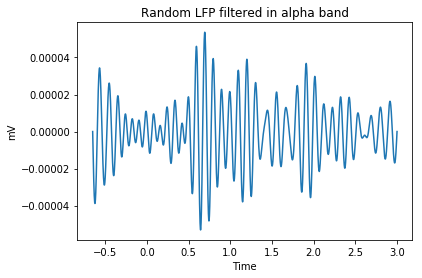

In [15]:
plt.plot(time, lfp_filterd )
plt.title('Random LFP filtered in alpha band')
plt.xlabel('Time')
plt.ylabel('mV')

Computing spectogram

In [16]:
idx = 30

W_morlet = spec._wavelet_spectrum(trial = 0, 
                 index_channel1 = idx, 
                 index_channel2 = None, 
                 n_cycles = freqs, 
                 smooth_window = 500, time_bandwidth = None, 
                 method = 'morlet', n_jobs = -1)

W_multitaper= spec._wavelet_spectrum(trial = 0, 
                 index_channel1 = idx, 
                 index_channel2 = None, 
                 n_cycles = freqs, 
                 smooth_window = 500, time_bandwidth = 8.0, 
                 method = 'multitaper', n_jobs = -1)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    2.6s finished


Text(0.5, 0, 'Time [s]')

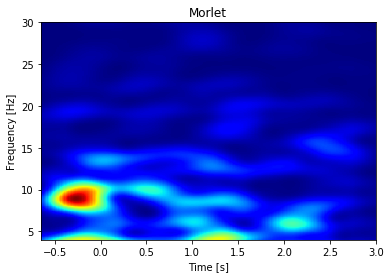

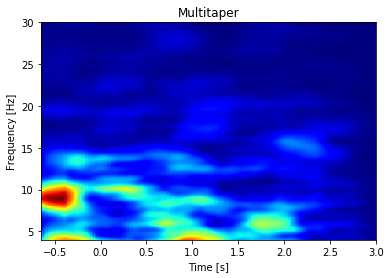

In [18]:
plt.title('Morlet')
plt.imshow(np.squeeze(W_morlet.real), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[-0.65, 3.00, 4, 30])
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.figure()
plt.title('Multitaper')
plt.imshow(np.squeeze(W_multitaper.real), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[-0.65, 3.00, 4, 30])
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')

If we indicate a second channel number both auto-(for each signal), and the cross-spectrum will be computed

In [19]:
Sxx, Syy, Sxy = spec._wavelet_spectrum(trial = 0, 
                                       index_channel1 = 10, 
                                       index_channel2 = 30, 
                                       n_cycles = freqs, 
                                       smooth_window = 500, time_bandwidth = None, 
                                       method = 'morlet', n_jobs = -1)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.4s finished


Text(0.5, 1.0, '$S_{xy}$')

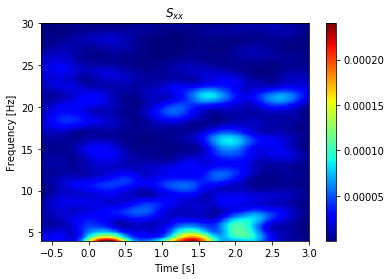

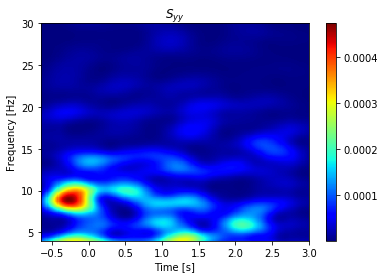

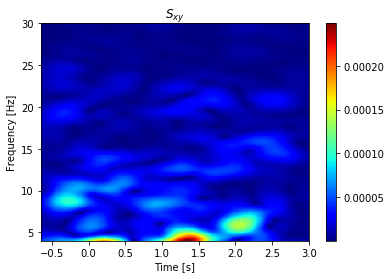

In [20]:
plt.figure()
plt.imshow(np.squeeze(Sxx.real), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[-0.65, 3.00, 4, 30])
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('$S_{xx}$')
plt.figure()
plt.imshow(np.squeeze(Syy.real), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[-0.65, 3.00, 4, 30])
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('$S_{yy}$')
plt.figure()
plt.imshow(np.squeeze(np.abs(Sxy)), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[-0.65, 3.00, 4, 30])
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('$S_{xy}$')

In [21]:
Sxx, Syy, Sxy = spec._wavelet_spectrum(trial = 0, 
                                       index_channel1 = 10, 
                                       index_channel2 = 30, 
                                       n_cycles = freqs, 
                                       smooth_window = 500, time_bandwidth = 8.0, 
                                       method = 'multitaper', n_jobs = -1)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    2.4s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    2.4s finished


Text(0.5, 1.0, '$S_{xy}$')

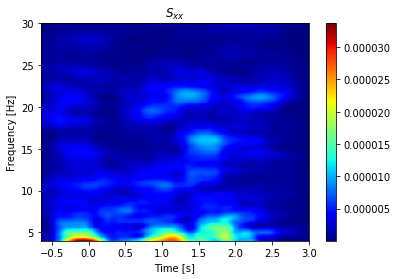

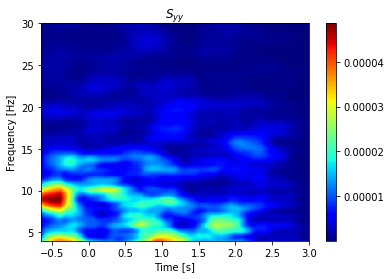

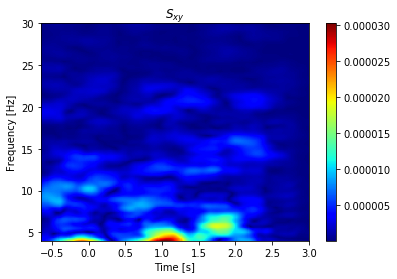

In [22]:
plt.figure()
plt.imshow(np.squeeze(Sxx.real), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[-0.65, 3.00, 4, 30])
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('$S_{xx}$')
plt.figure()
plt.imshow(np.squeeze(Syy.real), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[-0.65, 3.00, 4, 30])
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('$S_{yy}$')
plt.figure()
plt.imshow(np.squeeze(np.abs(Sxy)), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[-0.65, 3.00, 4, 30])
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('$S_{xy}$')

Finally, we can compute the coherence between a pair of signals

In [61]:
coh_morlet = spec._coherence(trial = 0, 
                             index_pair = 624, 
                             n_cycles = freqs/2.0, smooth_window = 500, 
                             time_bandwidth = None, method = 'morlet', n_jobs = 1)

coh_multitaper = spec._coherence(trial = 0, 
                                 index_pair = 624, 
                                 n_cycles = freqs/2.0, smooth_window = 500, 
                                 time_bandwidth = 8.0, method = 'multitaper', n_jobs = 1)

Text(0.5, 1.0, 'Multitaper')

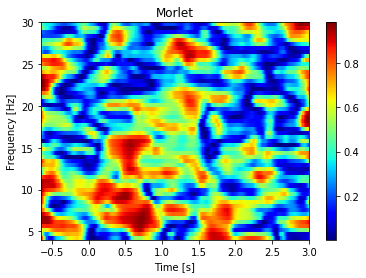

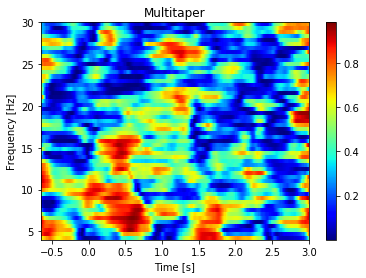

In [62]:
plt.figure()
plt.imshow(np.squeeze(coh_morlet.real), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[-0.65, 3.00, 4, 30])
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('Morlet')
plt.figure()
plt.imshow(np.squeeze(coh_multitaper.real), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[-0.65, 3.00, 4, 30])
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('Multitaper')

We can use the spectral analysis class to compute the pairwise coherence for the whole session with the method __session_coherence__.

In [34]:
import scipy

In [35]:
scipy.io.savemat('LFP.mat', {'lfp1': lfp, 'lfp2':lfp2})

In [24]:
W_morlet

array([[2.39447853e-05+0.j, 2.39508781e-05+0.j, 2.39570415e-05+0.j, ...,
        2.36006330e-05+0.j, 2.33954239e-05+0.j, 2.31906878e-05+0.j],
       [2.33558935e-05+0.j, 2.33626304e-05+0.j, 2.33694108e-05+0.j, ...,
        2.10439968e-05+0.j, 2.08603305e-05+0.j, 2.06771018e-05+0.j],
       [2.27786337e-05+0.j, 2.27860223e-05+0.j, 2.27934256e-05+0.j, ...,
        1.87041810e-05+0.j, 1.85405872e-05+0.j, 1.83773914e-05+0.j],
       ...,
       [1.06353060e-06+0.j, 1.06523964e-06+0.j, 1.06694808e-06+0.j, ...,
        3.49350769e-06+0.j, 3.46694949e-06+0.j, 3.44023780e-06+0.j],
       [1.07433817e-06+0.j, 1.07554326e-06+0.j, 1.07674502e-06+0.j, ...,
        3.53734703e-06+0.j, 3.51079226e-06+0.j, 3.48408296e-06+0.j],
       [1.08929455e-06+0.j, 1.09008664e-06+0.j, 1.09087321e-06+0.j, ...,
        3.57278487e-06+0.j, 3.54627048e-06+0.j, 3.51960084e-06+0.j]])

In [ ]:
coh_gb = spec.gabor_coherence(signal1=lfp, 
                              signal2=lfp2, 
                              fs=fs, freqs=freqs,n_cycles = 5.0,
                              win_time=500, win_freq = 1)

array([[0.98054276+0.j, 0.98027654+0.j, 0.98000785+0.j, ...,
        0.79555776+0.j, 0.7974773 +0.j, 0.79939601+0.j],
       [0.97490487+0.j, 0.97457493+0.j, 0.97424193+0.j, ...,
        0.82520148+0.j, 0.82692196+0.j, 0.82863915+0.j],
       [0.96920073+0.j, 0.96879759+0.j, 0.96839059+0.j, ...,
        0.85048278+0.j, 0.85205263+0.j, 0.85361699+0.j],
       ...,
       [0.46189124+0.j, 0.46307837+0.j, 0.46413358+0.j, ...,
        0.54822783+0.j, 0.5521835 +0.j, 0.55600747+0.j],
       [0.45965215+0.j, 0.46079885+0.j, 0.46181144+0.j, ...,
        0.546057  +0.j, 0.55004889+0.j, 0.55391   +0.j],
       [0.45698612+0.j, 0.45809421+0.j, 0.45906581+0.j, ...,
        0.54365667+0.j, 0.54768473+0.j, 0.55158304+0.j]])